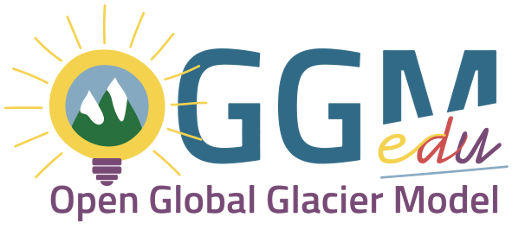

# Glacier surging experiments

Goals of this notebook:

- The student will be able to describe the effects of glacier surging.

- The student will be able to implement glacier surging in OGGM.

In this notebook we are going to explore the basic functionalities of OGGM flowline model(s) and perform a simple surging experiment. For this purpose we are going to use simple and "idealized" glacier models with simple linear mass-balance profiles. 

##### What is glacier surging?
A small percentage of glaciers undergo short periods of faster flow. They experience a change in morphology and surface characteristics, which sometimes leads to a marked frontal advance. The speed of the ice increases up to 10 - 1000 times of the normal velocity. Record flows are observed with velocities that exceed 100m per day. Surges happen in decadal cycles and can last for 1 up to 15 years.[¹](#Reference)

We start with importing all needed modules:

In [ ]:
# The commands below are just importing the necessary modules and functions
# Plot defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)  # Default plot size

# Scientific packages
import numpy as np

# Constants
from oggm import cfg
cfg.initialize()
# OGGM models
from oggm.core.massbalance import LinearMassBalance
from oggm.core.flowline import FluxBasedModel, RectangularBedFlowline, TrapezoidalBedFlowline, ParabolicBedFlowline

# There are several solvers in OGGM core. We use the default one for this experiment
from functools import partial
FlowlineModel = partial(FluxBasedModel, min_dt=0, cfl_number=0.01)

# OGGM Edu helper functions
import oggm_edu as edu

## Basics

First we set-up a simple run with a constant linear bedrock and a grid. We do similiar steps like in [flowline_model](http://edu.oggm.org/en/latest/notebooks_flowline_intro.html#glacier-flowline-modelling) to generate a set-up for our experiment.

In [ ]:
# This is the bed rock, linearily decreasing from 3400 m altitude to 1400 m, in 200 steps
nx = 200
bed_h = np.linspace(3400, 1400, nx)
# At the beginning, there is no glacier so our glacier surface is at the bed altitude
surface_h = bed_h
# Let's set the model grid spacing to 100 m 
map_dx = 100
# Calculate the corresponding distance along the glacier (from the top)
distance_along_glacier = np.linspace(0, nx, nx) * 0.1 # in km 
# The units of widths is in "grid points", i.e. 3 grid points = 300 m in our case
widths = np.zeros(nx) + 3.
# Define our bed
init_flowline = RectangularBedFlowline(surface_h=surface_h, bed_h=bed_h, widths=widths, map_dx=map_dx)

Then we define the equilibrium line altitude (ELA) for the mass balance model:

In [ ]:
# ELA at 3000m a.s.l., gradient 4 mm m-1
mb_model = LinearMassBalance(3000, grad=4)

Here we calculate a glacier that flows only because of deformation and  without sliding:

In [ ]:
# Define for how many years the glacier should be calculated
years = 600
# Initialize the model with the following function 
model = edu.init_model(init_flowline, mb_model=mb_model, years= years)
# Store the outline of the glacier as simple_glacier_h
simple_glacier_h = model.fls[-1].surface_h

In [ ]:
# Let's plot it!
plt.plot(distance_along_glacier, simple_glacier_h, label='Deforming glacier')
edu.plot_xz_bed(distance_along_glacier, bed_h)

## Surging glacier experiment

Since surging occurs because of increased basal sliding, a surging period can be represented in the model by increasing the sliding parameter[¹](#Reference), for example by a factor of 10. Typically surging can be assumend to happen cyclically after 100 years of normal sliding and lasts over a period of 10 years.

Let's model a simple glacier that only slides  (compare notebook [ice_flow_parameters]()):

In [ ]:
# Define parameters:
# Default in OGGM: Glen's creeping parameter
A = cfg.PARAMS['glen_a']
# Sliding glaciers (sliding parameter fs is nonzero)
fs = 5.7e-20
# Define for how many years the glacier should be calculated
years = 600

In [ ]:
# Initialize the model
model = edu.init_model(init_flowline, mb_model=mb_model, years=years, fs=fs)
# I store the final results for later use
sliding_glacier_h = model.fls[-1].surface_h

In [ ]:
# Let's plot both models.
plt.plot(distance_along_glacier, simple_glacier_h, label='Deforming glacier')
plt.plot(distance_along_glacier, sliding_glacier_h, label='Sliding glacier')
edu.plot_xz_bed(distance_along_glacier, bed_h)

Now we calculate a surging glacier:

In [ ]:
# Define parameters:
# Sliding parameter in times of slow sliding:
fs = 5.7e-20
# Sliding parameter in surging periods:
fs_surge = 5.7e-20*10
# Surging period:
period_s = 10
# Time span between 2 surging periods:
t_slow = 100
# Number of surges
no_surges = 10

In [ ]:
# Surging glaciers - model initialisation
model = FlowlineModel(init_flowline, mb_model=mb_model, y0=0., glen_a=A, fs=fs)

# 10 periods of 10 years surging every 100 years
yrs = np.arange(0,t_slow + 1,10)
for i in np.arange(0,no_surges,1):
    yrs_sliding = np.arange(t_slow+1+t_slow*i+period_s*i, t_slow+period_s+1+t_slow*i+period_s*i,1)
    yrs = np.append(yrs, yrs_sliding)
    
    yrs_normal = np.arange(t_slow+period_s+10+t_slow*i+period_s*i, 2*t_slow+period_s+10+t_slow*i+period_s*i, 10)
    yrs = np.append(yrs, yrs_normal)

If it is still unclear to you which years are "surging years", have a look into the list "yrs":

In [ ]:
yrs

In [ ]:
# Calculation of the glacier outline after going through the chosen number of surges
model = edu.surging_glacier(yrs, init_flowline, mb_model, bed_h, widths, map_dx, A, fs, fs_surge, model)
surging_glacier_h_weak = model[0].fls[-1].surface_h

Now we plot the different calculated glacier:

In [ ]:
# Plot the results
f, ax = plt.subplots(figsize=(9, 6))
plt.plot(distance_along_glacier, simple_glacier_h, label='Deforming glacier')
plt.plot(distance_along_glacier, sliding_glacier_h, label='Sliding glacier')
plt.plot(distance_along_glacier, surging_glacier_h_weak, label='Weak surging glacier')
# Add the bedrock
edu.plot_xz_bed(distance_along_glacier, bed_h)

We now increase the sliding parameter in order to increase surges:

In [ ]:
# Define parameters:
# Sliding parameter in times of normal sliding:
fs = 5.7e-20
# Sliding parameter in surging periods:
fs_surge = 5.7e-20*50

# Calculation of the glacier outline
model = FlowlineModel(init_flowline, mb_model=mb_model, y0=0., glen_a=A, fs=fs)
strong_surge_model = edu.surging_glacier(yrs, init_flowline, mb_model, bed_h, widths, map_dx, A, fs, fs_surge, model)
surging_glacier_h = strong_surge_model[0].fls[-1].surface_h

In [ ]:
# Plot the results
f, ax = plt.subplots(figsize=(9, 6))
plt.plot(distance_along_glacier, simple_glacier_h, label='Deforming glacier')
plt.plot(distance_along_glacier, sliding_glacier_h, label='Sliding glacier')
plt.plot(distance_along_glacier, surging_glacier_h_weak, label='Weak surging glacier')
plt.plot(distance_along_glacier, surging_glacier_h, label='High surging glacier')
# Add the bedrock
edu.plot_xz_bed(distance_along_glacier, bed_h)

Compare the different glacier types. How can you explain the differences?

We now plot the different glacier shapes after each surge. (If it does not work properly, run the cell again).

In [ ]:
# Plot the intermediate steps of surging glacier
%matplotlib notebook
import matplotlib.pyplot as plt
import ipywidgets

# Plotting the bed
f, ax = plt.subplots(figsize=(9, 6))
ax.plot(strong_surge_model[0].fls[-1].bed_h, color='k', label='Bedrock')

# Plotting the first surface
gl = ax.plot(strong_surge_model[1][0], label='Glacier')[0]
plt.tight_layout()
plt.legend();

# Plotting glacier evolution - NOT ALWAYS WORKING PROPERLY
def plot_func(freq):
    gl.set_ydata(strong_surge_model[1][freq])
    f.canvas.draw()
    
freq = ipywidgets.IntSlider(value=0, min=0, max=len(strong_surge_model[1])-1, step=1, description='Surge:')
ipywidgets.interact(plot_func, freq=freq);

## Reference

¹ Hester Jiskoot: Glacier Surging. In: Vijay P. Singh, Pratap Singh, Umesh K. Haritashya (Hrsg.): Encyclopedia of Snow, Ice and Glaciers. Springer, Dordrecht 2011, S. 415–428, ISBN 978-90-481-2641-5